In [1]:
import pyart
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
from pyproj import Proj, CRS, Transformer
import glob
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
from scipy.interpolate import griddata
from collections import defaultdict
from scipy.spatial import KDTree


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Date of the data
year = '2025'
month = '03'
day = '13'

# The path to the data directory
# The data is stored in the following directory structure
# /mnt/gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y2025/M03/D13/
# The year, month and day are used to construct the path
data='/gws/nopw/j04/tone_ico_gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y'+year+'/M'+month+'/D'+day+'/*el_18*PPI.LV1.NC'
file_list = sorted(glob.glob(data))  

In [3]:
# Takes in the raw data and a target grid, extracts reflectivity and regrids to the target grid
def extractFields(ds, lat_target, lon_target):
    # === Extract reflectivity ===
    cze_vars = ['C1ZE45', 'C2ZE45', 'C3ZE45', 'C4ZE45']
    range_vars = [var.replace('ZE45', 'Range') for var in cze_vars]
    data_list = [ds[var].values for var in cze_vars]
    range_list = [ds[var].values for var in range_vars]

    # Stack reflectivity and range
    data_stacked = np.concatenate(data_list, axis=1)  # (n_az, total_range)
    ranges_stacked = np.concatenate(range_list)       # (total_range,)

    # Filter low reflectivity
    data_stacked[data_stacked < -30] = np.nan

    # === Get azimuths ===
    n_az = data_stacked.shape[0]
    azimuths = np.linspace(0, 2 * np.pi, n_az, endpoint=False)

    azimuths_2d, ranges_2d = np.meshgrid(azimuths, ranges_stacked, indexing='ij')
    X = ranges_2d * np.cos(azimuths_2d)
    Y = ranges_2d * np.sin(azimuths_2d)

    # === Polar to lat/lon ===
    trollLat = ds['GPSLat'].values.item()
    trollLon = ds['GPSLon'].values.item()
    crs_centered = CRS.from_proj4(f"+proj=aeqd +lat_0={trollLat} +lon_0={trollLon} +datum=WGS84 +units=m +no_defs")
    crs_geo = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(crs_centered, crs_geo, always_xy=True)
    lon, lat = transformer.transform(X, Y)

    # === Interpolate reflectivity onto target grid ===
    points = np.column_stack((lat.ravel(), lon.ravel()))
    values = data_stacked.ravel()
    dbz_interp = griddata(points, values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    # === Interpolate time onto target grid ===
    # Time is in seconds since 2001-01-01 00:00:00
    time_array = ds['Time'].values.astype(float)  # shape: (n_az,)
    base = np.datetime64('2001-01-01T00:00:00', 's')

    # Convert to datetime and then seconds since midnight
    absolute_times = base + time_array.astype('timedelta64[s]')
    seconds_since_midnight = (absolute_times - absolute_times.astype('datetime64[D]')).astype('timedelta64[s]').astype(float)

    # Expand time to match (n_az, n_range)
    time_2d = np.repeat(seconds_since_midnight[:, np.newaxis], data_stacked.shape[1], axis=1)

    # Interpolate time field onto the same target grid
    time_values = time_2d.ravel()
    time_interp = griddata(points, time_values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    return dbz_interp, time_interp

In [4]:
# converts dbz to snowfall rate - ADJUST A, B (Souverijns et al. 2017) as needed
def zToSR(dbz, a, b):
    dbz[dbz > 1000] = np.nan
    #z = 10 ** (dbz / 10)

    rate = (dbz / a) ** (1 / b)
    return rate

In [5]:
# generating the target uniform lat/lon grid
lat_grid = np.arange(-72.15, -71.85, 0.001)
lon_grid = np.arange(2, 3, 0.001)
lon_target, lat_target = np.meshgrid(lon_grid, lat_grid)
nlon, nlat = len(lon_grid), len(lat_grid)

timesteps = len(file_list)

timeGrid = np.empty((nlat, nlon, timesteps))
dbzGrid = np.empty((nlat, nlon, timesteps))
snowGrid = np.empty((nlat, nlon, timesteps))


# iterating over all the hourly radar scans during the given day, and storing in a common data structure on a common grid
k = 0
for file in file_list[5:]:
    print(k)
    ds = xr.open_dataset(file)
    print(k)

    # Step 1: Extract reflectivity and time, interpolate to lat/lon
    dbz_interp, time_interp = extractFields(ds, lat_target, lon_target)

    a = 18
    b = 1.1

    # Step 2: Convert to snowfall rate
    snowfall_rate = zToSR(dbz_interp, a, b)

    # Step 3: Populate the (lat x lon x time) arrays for time, dbz, snowfall rate
    timeGrid[:, :, k] = time_interp
    dbzGrid[:, :, k] = dbz_interp 
    snowGrid[:, :, k] = snowfall_rate
    
    k = k + 1

# Sort the arrays by time
sort_indices = np.argsort(timeGrid, axis=2)

timeSort_0313 = np.take_along_axis(timeGrid, sort_indices, axis=2)
dbzSort_0313 = np.take_along_axis(dbzGrid, sort_indices, axis=2)
snowSort_0313 = np.take_along_axis(snowGrid, sort_indices, axis=2)

0
0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18


In [6]:
# Computes a definite integral over some bounds with trapezoidal integration
def defIntegral(x, y, a, b, axis=-1):

   # Move integration axis to the last axis for easier manipulation
    x = np.moveaxis(x, axis, -1)
    y = np.moveaxis(y, axis, -1)

    # Shape info
    spatial_shape = x.shape[:-1]
    nt = x.shape[-1]

    # Prepare an output array for results
    result_shape = spatial_shape
    result = np.zeros(result_shape)

    # For each spatial point, integrate along the last axis over [a,b]
    # We'll loop over spatial points (should be vectorized if possible, but this is clear)
    it = np.nditer(result, flags=['multi_index'], op_flags=['writeonly'])

    while not it.finished:
        idx = it.multi_index  # spatial indices

        x_line = x[idx]  # 1D array shape (nt,)
        y_line = y[idx]  # 1D array shape (nt,)

        # Find indices inside the interval
        inside = (x_line >= a) & (x_line <= b)

        if not np.any(inside):
            # No points in interval => integral = 0
            it[0] = 0
            it.iternext()
            continue

        # Extract inside points
        x_sub = x_line[inside]
        y_sub = y_line[inside]

        # Interpolate y at the boundaries if needed
        if x_sub[0] > a:
            y_a = np.interp(a, x_line, y_line)
            x_sub = np.insert(x_sub, 0, a)
            y_sub = np.insert(y_sub, 0, y_a)

        if x_sub[-1] < b:
            y_b = np.interp(b, x_line, y_line)
            x_sub = np.append(x_sub, b)
            y_sub = np.append(y_sub, y_b)

        # Compute trapezoidal integral for this spatial point
        integral = np.trapz(y_sub, x_sub)

        it[0] = integral
        it.iternext()

    return result

In [34]:
def weightedAvg(y):
    """
    Compute weighted local averages along axis=2 for a 3D array,
    handling NaNs by excluding them and rescaling weights.

    - Forward:   (2*y[0] + y[1]) / (sum of weights that are not NaN)
    - Central:   (y[i-1] + 2*y[i] + y[i+1]) / (sum of weights that are not NaN)
    - Backward:  (y[-2] + 2*y[-1]) / (sum of weights that are not NaN)

    Parameters:
        y (ndarray): 3D array (nx, ny, nt)

    Returns:
        avg (ndarray): 3D array of same shape, with local weighted averages
    """
    y = np.asarray(y)
    nx, ny, nt = y.shape
    avg = np.full_like(y, np.nan, dtype=np.float64)

    # Forward difference at index 0
    y0 = y[:, :, 0]
    y1 = y[:, :, 1]
    weights = (~np.isnan(y0)).astype(float) * 2 + (~np.isnan(y1)).astype(float)
    vals = np.nan_to_num(y0) * 2 + np.nan_to_num(y1)
    avg[:, :, 0] = np.where(weights > 0, vals / weights, np.nan)

    # Central differences
    for i in range(1, nt - 1):
        ym = y[:, :, i - 1]
        yc = y[:, :, i]
        yp = y[:, :, i + 1]

        weights = (
            (~np.isnan(ym)).astype(float) +
            2 * (~np.isnan(yc)).astype(float) +
            (~np.isnan(yp)).astype(float)
        )
        vals = (
            np.nan_to_num(ym) +
            2 * np.nan_to_num(yc) +
            np.nan_to_num(yp)
        )
        avg[:, :, i] = np.where(weights > 0, vals / weights, np.nan)

    # Backward difference at index -1
    y_1 = y[:, :, -1]
    y_2 = y[:, :, -2]
    weights = (~np.isnan(y_2)).astype(float) + 2 * (~np.isnan(y_1)).astype(float)
    vals = np.nan_to_num(y_2) + 2 * np.nan_to_num(y_1)
    avg[:, :, -1] = np.where(weights > 0, vals / weights, np.nan)

    return avg

In [35]:
hourlyAccum_0313 = weightedAvg(snowSort_0313)

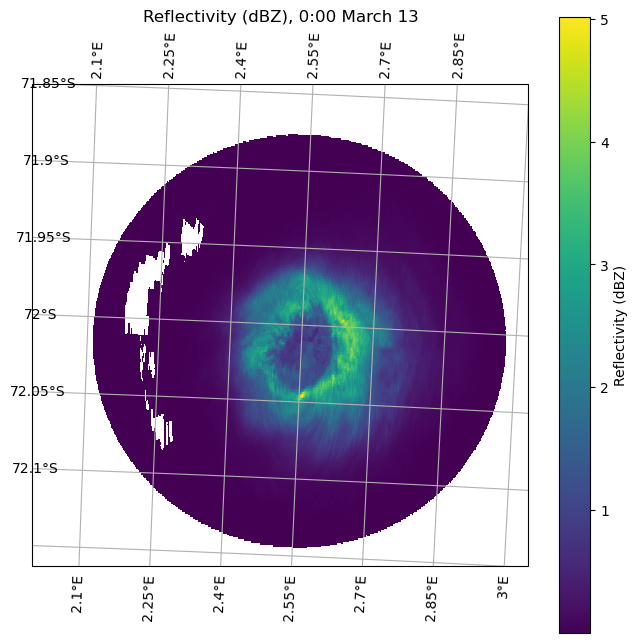

In [38]:
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.gridlines(draw_labels=True)
ax.set_extent([2, 3, -72.15, -71.85], crs=ccrs.PlateCarree())
ax.coastlines()



cf = ax.pcolormesh(lon_target, lat_target, hourlyAccum_0313[:, :, 22], transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity (dBZ), 0:00 March 13")

plt.show()

NameError: name 'dbz_Interp' is not defined

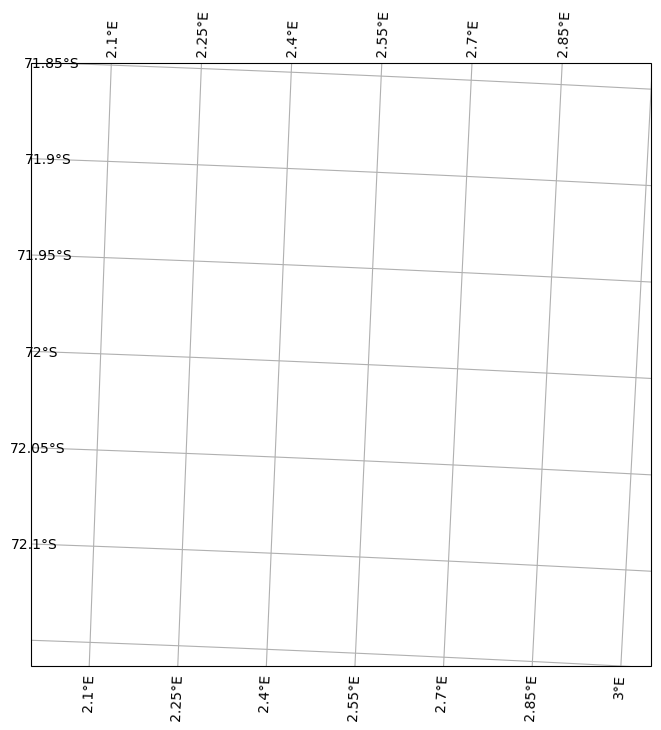

In [28]:
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.gridlines(draw_labels=True)
ax.set_extent([2, 3, -72.15, -71.85], crs=ccrs.PlateCarree())
ax.coastlines()



cf = ax.pcolormesh(lon_target, lat_target, dbz_Interp[:, :, 11], transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Snow accumulation (mm)')
plt.title("Hourly accumulation (mm), 0:00 March 13")

plt.show()

In [ ]:
#file_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/neumayer/radar/20230426_neumayer_mira.nc'
modfile_path = '/gws/nopw/j04/tone_ico_gws/cloudnet/troll/era5/8c77d7d4c6e1d8b637bca6cfa6a85450.nc'
model = nc.Dataset(modfile_path)


In [ ]:
# Coords of Neumayer III
fullGrid = np.array(model.variables['mxtpr'][288:336, 30:60, 500:900]) * 60 * 60


In [ ]:
eraLat = np.array(model.variables['latitude'][30:60]) 

In [ ]:
eraLon = np.array(model.variables['longitude'][500:900]) 

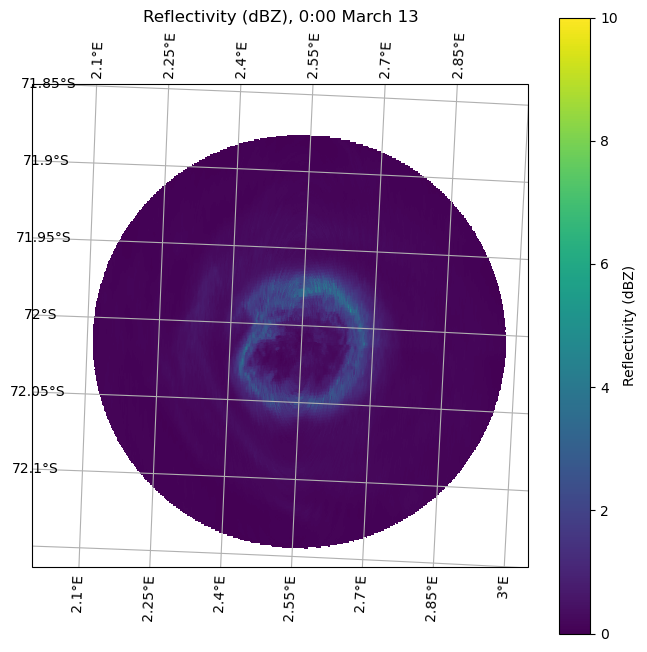

In [16]:
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.gridlines(draw_labels=True)
ax.set_extent([2, 3, -72.15, -71.85], crs=ccrs.PlateCarree())
ax.coastlines()



cf = ax.pcolormesh(lon_target, lat_target, dbzSort_0313[:, :, 5], vmin=0, vmax=10, transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity (dBZ), 0:00 March 13")

plt.show()